In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

In [2]:
data=yf.download('0700.hk')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2022-03-30,383.000000,388.600006,380.200012,380.600006,380.600006,26951872,372.600001,369.333333,52.979983,-21.276592,-43.726231,-7.399994,48.800018,375.239148,389.873328,-14.634180,11.399994,9.571940,-4.034221,374.200012
2022-03-31,382.399994,382.399994,372.600006,374.200012,374.200012,14589554,370.133336,375.683334,48.946234,-38.297850,-55.893518,-14.799988,76.200012,375.079281,388.712342,-13.633061,9.799988,-0.625479,-8.055103,378.799988
2022-04-01,367.000000,378.799988,362.200012,378.799988,378.799988,14496674,372.266668,376.666667,52.010099,-28.323747,-47.148318,12.799988,11.799988,375.651697,387.978094,-12.326396,16.599976,6.851465,-4.618128,390.000000
2022-04-04,388.799988,391.000000,383.799988,390.000000,390.000000,15665556,377.866669,376.666667,58.999512,-3.472224,-25.855522,33.600006,0.000000,377.859129,388.127864,-10.268736,12.200012,23.466838,3.532026,381.000000
2022-04-06,383.000000,385.000000,380.000000,381.000000,381.000000,17127923,380.300003,376.666667,51.911489,-34.722237,-42.965786,14.600006,0.000000,378.342340,387.599874,-9.257535,10.000000,5.346744,-3.086421,374.399994


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_51468/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


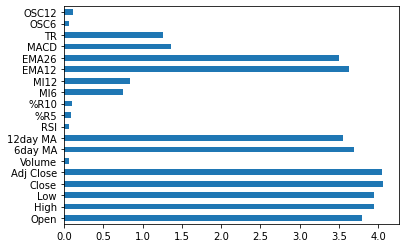

In [6]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [7]:
# X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3416, 1, 19) (3416, 1) (854, 1, 19) (854, 1)


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-11 06:03:36.406177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-11 06:03:36.406279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-11 06:03:36.837524: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-11 06:03:38.147616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:03:38.369312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:03:38.403127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:03:38.477573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:03:38.540077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


193/193 [==============================] - ETA: 0s - loss: 173.0465

2022-04-11 06:03:41.131513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:03:41.211791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:03:41.235025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


193/193 [==============================] - 5s 15ms/step - loss: 173.0465 - val_loss: 46703.0000
Epoch 2/500
193/193 [==============================] - 2s 11ms/step - loss: 5864.8076 - val_loss: 72699.5234
Epoch 3/500
193/193 [==============================] - 2s 11ms/step - loss: 3778.1189 - val_loss: 72369.6172
Epoch 4/500
193/193 [==============================] - 2s 11ms/step - loss: 3729.5024 - val_loss: 72108.2031
Epoch 5/500
193/193 [==============================] - 2s 11ms/step - loss: 3722.5947 - val_loss: 71988.0312
Epoch 6/500
193/193 [==============================] - 2s 11ms/step - loss: 3719.1565 - val_loss: 71954.9375
Epoch 7/500
193/193 [==============================] - 2s 11ms/step - loss: 3716.4976 - val_loss: 71974.4297
Epoch 8/500
193/193 [==============================] - 2s 11ms/step - loss: 3714.1892 - val_loss: 72029.3047
Epoch 9/500
193/193 [==============================] - 2s 13ms/step - loss: 3712.0610 - val_loss: 72110.3125
Epoch 10/500
193/193 [==========

Epoch 76/500
193/193 [==============================] - 2s 11ms/step - loss: 142.4141 - val_loss: 19543.9805
Epoch 77/500
193/193 [==============================] - 2s 11ms/step - loss: 142.2934 - val_loss: 19387.7617
Epoch 78/500
193/193 [==============================] - 2s 11ms/step - loss: 142.2667 - val_loss: 19286.4199
Epoch 79/500
193/193 [==============================] - 2s 11ms/step - loss: 142.1241 - val_loss: 19200.1309
Epoch 80/500
193/193 [==============================] - 2s 11ms/step - loss: 142.2842 - val_loss: 19112.0664
Epoch 81/500
193/193 [==============================] - 2s 11ms/step - loss: 142.6664 - val_loss: 19024.2793
Epoch 82/500
193/193 [==============================] - 2s 11ms/step - loss: 143.0571 - val_loss: 18940.7363
Epoch 83/500
193/193 [==============================] - 2s 11ms/step - loss: 143.3804 - val_loss: 18861.6582
Epoch 84/500
193/193 [==============================] - 2s 11ms/step - loss: 143.6311 - val_loss: 18786.8223
Epoch 85/500
193/19

Epoch 151/500
193/193 [==============================] - 2s 9ms/step - loss: 98.5601 - val_loss: 18061.2578
Epoch 152/500
193/193 [==============================] - 2s 9ms/step - loss: 107.0054 - val_loss: 17107.2441
Epoch 153/500
193/193 [==============================] - 2s 10ms/step - loss: 113.4786 - val_loss: 17410.1367
Epoch 154/500
193/193 [==============================] - 2s 9ms/step - loss: 103.9303 - val_loss: 18156.4863
Epoch 155/500
193/193 [==============================] - 2s 9ms/step - loss: 94.6905 - val_loss: 18908.8359
Epoch 156/500
193/193 [==============================] - 2s 9ms/step - loss: 88.5697 - val_loss: 19235.3730
Epoch 157/500
193/193 [==============================] - 2s 9ms/step - loss: 87.2340 - val_loss: 19291.7168
Epoch 158/500
193/193 [==============================] - 2s 9ms/step - loss: 87.5756 - val_loss: 18915.6309
Epoch 159/500
193/193 [==============================] - 2s 9ms/step - loss: 91.8768 - val_loss: 18229.3340
Epoch 160/500
193/193 [=

193/193 [==============================] - 2s 9ms/step - loss: 66.9202 - val_loss: 18705.2012
Epoch 227/500
193/193 [==============================] - 2s 9ms/step - loss: 62.5122 - val_loss: 19162.2637
Epoch 228/500
193/193 [==============================] - 2s 9ms/step - loss: 58.4238 - val_loss: 19349.4277
Epoch 229/500
193/193 [==============================] - 2s 10ms/step - loss: 58.4618 - val_loss: 18946.1289
Epoch 230/500
193/193 [==============================] - 2s 9ms/step - loss: 63.7219 - val_loss: 18012.0781
Epoch 231/500
193/193 [==============================] - 2s 9ms/step - loss: 71.3937 - val_loss: 17944.7598
Epoch 232/500
193/193 [==============================] - 3s 13ms/step - loss: 68.4970 - val_loss: 18403.2344
Epoch 233/500
193/193 [==============================] - 2s 11ms/step - loss: 62.6422 - val_loss: 18886.7520
Epoch 234/500
193/193 [==============================] - 2s 13ms/step - loss: 57.9886 - val_loss: 19249.2070
Epoch 235/500
193/193 [===============

Epoch 302/500
193/193 [==============================] - 2s 9ms/step - loss: 54.5266 - val_loss: 18967.4922
Epoch 303/500
193/193 [==============================] - 2s 9ms/step - loss: 52.5860 - val_loss: 19059.5449
Epoch 304/500
193/193 [==============================] - 2s 9ms/step - loss: 53.4159 - val_loss: 18678.8125
Epoch 305/500
193/193 [==============================] - 2s 9ms/step - loss: 56.3799 - val_loss: 18191.4551
Epoch 306/500
193/193 [==============================] - 2s 9ms/step - loss: 57.1171 - val_loss: 18197.2969
Epoch 307/500
193/193 [==============================] - 2s 9ms/step - loss: 54.4541 - val_loss: 18516.3672
Epoch 308/500
193/193 [==============================] - 2s 9ms/step - loss: 51.6117 - val_loss: 18817.4863
Epoch 309/500
193/193 [==============================] - 2s 9ms/step - loss: 50.1836 - val_loss: 19009.8262
Epoch 310/500
193/193 [==============================] - 2s 9ms/step - loss: 50.0295 - val_loss: 19031.1152
Epoch 311/500
193/193 [=====

Epoch 378/500
193/193 [==============================] - 2s 9ms/step - loss: 51.6608 - val_loss: 18722.2402
Epoch 379/500
193/193 [==============================] - 2s 9ms/step - loss: 50.1726 - val_loss: 18910.3301
Epoch 380/500
193/193 [==============================] - 2s 9ms/step - loss: 48.2341 - val_loss: 19061.6777
Epoch 381/500
193/193 [==============================] - 2s 9ms/step - loss: 48.9478 - val_loss: 18724.6309
Epoch 382/500
193/193 [==============================] - 2s 9ms/step - loss: 59.5010 - val_loss: 16990.0156
Epoch 383/500
193/193 [==============================] - 2s 9ms/step - loss: 76.0413 - val_loss: 17062.1016
Epoch 384/500
193/193 [==============================] - 2s 9ms/step - loss: 69.2256 - val_loss: 18053.8691
Epoch 385/500
193/193 [==============================] - 2s 9ms/step - loss: 52.7662 - val_loss: 18715.5723
Epoch 386/500
193/193 [==============================] - 2s 9ms/step - loss: 47.2451 - val_loss: 18936.2852
Epoch 387/500
193/193 [=====

Epoch 454/500
193/193 [==============================] - 2s 9ms/step - loss: 38.6502 - val_loss: 18648.3926
Epoch 455/500
193/193 [==============================] - 2s 9ms/step - loss: 40.9350 - val_loss: 18560.4004
Epoch 456/500
193/193 [==============================] - 2s 9ms/step - loss: 43.6259 - val_loss: 18337.6230
Epoch 457/500
193/193 [==============================] - 2s 9ms/step - loss: 45.4085 - val_loss: 18073.7422
Epoch 458/500
193/193 [==============================] - 2s 9ms/step - loss: 46.0397 - val_loss: 18157.4277
Epoch 459/500
193/193 [==============================] - 2s 9ms/step - loss: 44.2300 - val_loss: 18456.4512
Epoch 460/500
193/193 [==============================] - 2s 9ms/step - loss: 41.2526 - val_loss: 18664.9824
Epoch 461/500
193/193 [==============================] - 2s 9ms/step - loss: 40.0272 - val_loss: 18760.8750
Epoch 462/500
193/193 [==============================] - 2s 9ms/step - loss: 41.4717 - val_loss: 18544.8906
Epoch 463/500
193/193 [=====

2022-04-11 06:19:19.393590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:19:19.459608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 06:19:19.524265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


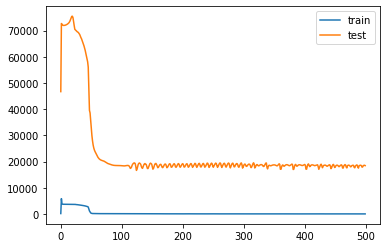

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

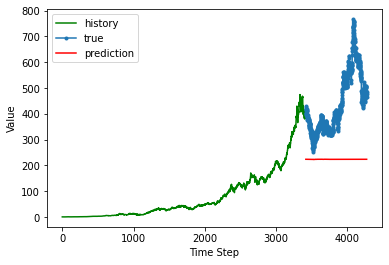

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

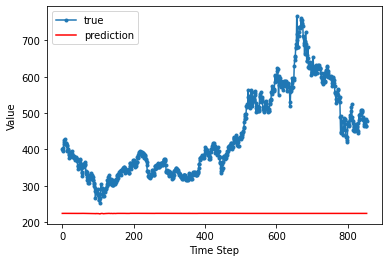

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

-3.4687284682265123

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.4570365788003586

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

244.71179457965638

In [16]:
x_val=data_val.drop(['Prediction'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_51468/2648236666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction'],1)


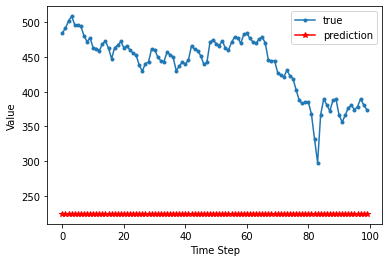

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

-26.27938566207309

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.4855379440174091

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

219.94068809395435